In [1]:
import datetime as dt
import pandas as pd
import numpy as np

online_path = r"../input/chap-2/online12M.csv"
online = pd.read_csv(online_path)
online = online.iloc[:, 1:]

online['Total_Sum'] = online['Quantity'] * online['UnitPrice']
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days = 1)
datamart = online.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                                'InvoiceNo': 'count',
                                                'Total_Sum': 'sum'
                                               })

online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Sum
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom,12.60
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom,1.45
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom,22.50
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom,2.10
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom,17.85


## 1. Practical implementation of k-means clustering
Great job! Now we are entering the final and the most important part of this course - we will implement a segmentation project with k-means clustering using the data we have prepared in the previous lessons.

#### Key steps
The key steps of the segmentation projects are the following ones: 
- First, we **pre-process the data**, which we covered in the previous lessons. 
- Then, we have to **choose the number of clusters** as k-means requires that number to be passed to it. 
- We will then **run the `k-means clustering`** and receive a list of cluster labels for each customer. 
- Finally, we will analyze the average recency, frequency and monetary values for each cluster and compare them.

#### Data pre-processing
- 1. As we have already covered data pre-processing in the [previous lesson](https://github.com/Nhan121/Lectures_notes-teaching-in-VN-/blob/master/Statistics/Machine%20Learning/Clustering%20%26%20Segmentation/Customer%20Segmentation/Data%20pre-processing%20for%20clustering.ipynb), we will just reiterate the learnings. We have the raw and the pre-processed datasets loaded as `datamart_rfm`

In [2]:
datamart_rfm = datamart.rename(columns = {'InvoiceDate': 'Recency',
                                        'InvoiceNo' : 'Frequency',
                                        'Total_Sum' : 'Monetary_Value'
                                     },
                             inplace = False
                            )
datamart_rfm.head()

,Recency,Frequency,Monetary_Value
CustomerID,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


and `datamart_normalized` respectively. 

- Finally, it scales it by dividing it by standard deviation.

In [3]:
datamart_log = np.log(datamart_rfm)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

datamart_normalized = scaler.fit_transform(datamart_log)

#### Methods to define the number of clusters
When running k-means you will have to pass the number of clusters. This decision is not an easy one, if there are no data supporting the choice. Fortunately, there are various methods to get a good estimate on what it should be:
- We will use visual methods such as **elbow criterion** since they are easy to interpret and give a good estimation. 
- There are also mathematical methods like **silhouette coefficient** which is useful when trying to find a model with better defined clusters. Not without its caveats, but still commonly used. We won't be using this method for our segmentation project. 
- Finally, it's important to understand that these methods should be interpreted as advisory as we are segmenting customers. Each solution's **interpretation** should make sense for the business first, and be actionable.

#### Running k-means
Running k-means is a pretty straightforward process: 
- First we import `KMeans` from the `scikit-learn library`.

In [4]:
from sklearn.cluster import KMeans

 Then we initialize the model by passing the number of clusters and any integer as the random state.

In [5]:
kmeans = KMeans(n_clusters = 2, random_state = 1)

Then, we compute the k-means clustering on our pre-processed data with the fit() function.

In [6]:
kmeans.fit(datamart_normalized)

KMeans(n_clusters=2, random_state=1)

Finally we extract the computer cluster labels. That's it!

In [7]:
kmeans.labels_

array([1, 1, 1, ..., 0, 1, 1], dtype=int32)

#### Analyzing average RFM values of each cluster
The next step is to analyze how these clusters differ from each other, and we will do that with the raw data.
- First, we will create a new dataframe that has raw RFM columns, plus a cluster column which we add with the assign() command. 
- Then we take the new DataFrame and calculate average RFM values for each cluster, and count the number of observations in each cluster.

In [8]:
# create a cluster
datamart_rfm_k2 = datamart_rfm.assign(Cluster = kmeans.labels_)

# calculate avg-rfm value
datamart_rfm_k2.groupby('Cluster').agg({'Recency': 'mean',
                                        'Frequency' : 'mean',
                                        'Monetary_Value': ['mean', 'count']
                                       }).round(0)

Recency Frequency Monetary_Value      
           mean      mean           mean count
Cluster                                       
0         137.0       5.0           92.0  2023
1          32.0      35.0          719.0  1620

The result is a simple table where we see how these two segments differ from each other. 

It's clear that segment 0 has customers who have not been very recent, are much less frequent with their purchases and their monetary value is much lower than that of segment 1. 

This is already a clear distinction and quite a useful segmentation. We will see in the next lesson that more insights can be uncovered by increasing the number of segments.

### 1.2. PRACTICES
#### Exercise 1.2.1. Run k-means
You will now build a 3 clusters with k-means clustering. We have loaded the pre-processed RFM dataset as datamart_normalized. We have also loaded the pandas library as pd.

#### SOLUTION.

In [9]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

#### Exercise 1.2.2. Assign labels to raw data
You will now analyze the average RFM values of the three clusters you've created in the previous exercise. We have loaded the raw RFM dataset as datamart_rfm, and the cluster labels as cluster_labels. pandas is available as pd.
#### SOLUTION.

In [10]:
# Create a DataFrame by adding a new cluster label column
datamart_rfm_k3 = datamart_rfm.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary_Value': ['mean', 'count']
          }).round(1)

Recency Frequency Monetary_Value      
           mean      mean           mean count
Cluster                                       
0          16.1      50.1         1050.6   901
1         166.6       3.0           53.0  1156
2          77.1      12.3          216.0  1586

## 2. Choosing number of clusters
Now we will learn how to choose the number of clusters we want to use with k-means.
#### Methods
We have learned in the previous lesson that there are several ways to do this - visually, mathematically, or experimenting with different clusters and interpreting the results. We will focus on the elbow criterion and the experimentation. 
- First, we will learn how to identify the best advised number of segments by elbow criterion method. 
- Then, we will experiment with several numbers of clusters around it.

#### Elbow criterion method
The elbow criterion method plots the **sum of squared errors (SSE)** for each number of segments. 
- The sum of squared errors is basically the sum of squared distances from each data point to their cluster center. 
- We then look at the chart to identify where the decrease in **SSE** slows down and becomes somewhat marginal. That point looks like an elbow of a bended arm and it shows where there are diminishing returns by increasing the number of clusters. This point represents the optimal number of clusters from a sum-of-squared errors perspective. 

However, we should choose several options around the elbow to test what makes most sense.

Let's take a look at the code to build the elbow criterion plot.
- We are using a dummy data to emphasize the concept. First, we import the key libraries for plotting and kmeans. Then, we create an empty dictionary called SSE, abbreviation for sum of squared errors, and we run a for loop over different number of clusters, between 1 and 10.

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

SSE = {}


- For each iteration we build a kmeans segmentation on the pre-processed data. The fitted kmeans model already has a sum of squared errors calculated and stored as inertia. We will assign it to the dictionary we created. 

In [12]:
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 1)
    kmeans.fit(datamart_normalized)
    SSE[k] = kmeans.inertia_

- Finally we plot the number of clusters stored as keys in the dictionary on the x axis, and the sum-of-squared error values on the y axis.

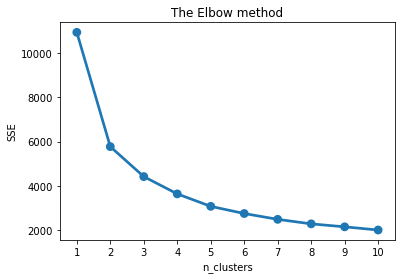

In [13]:
plt.title('The Elbow method')
plt.xlabel('n_clusters')
plt.ylabel('SSE')
sns.pointplot(x = list(SSE.keys()),
              y = list(SSE.values()))
plt.show()

And here's what we get: the elbow plot! The way to look at it is try to find the point with the largest angle which is the so-called elbow.

The point at `4 clusters` is where we identify the largest angle, and this is the elbow we've been looking for.

#### Using elbow criterion method
It's important to understand that building segmentation only at that number of clusters is not a hard rule. Generally, it should be taken as a recommended number and we should test several segmentation approaches. Here we can see the elbow plot for our RFM data. It's pretty clear the elbow is at the 2 cluster solution. But we will definitely test several approaches.

#### Experimental approach - analyze segments
Finally, there is the experimental approach to choose the number of customers which is best used after identifying an elbow or another computationally advised number of segments. For each of these numbers we will calculate the average RFM or other attribute values, and compare the solutions to identify the approach that is the most useful and provides most insight.

For example, the elbow criterion plot for RFM data advised 2 clusters, therefore, we should at least build segmentation based on 2 and 3 clusters, and compare the outputs. 

In [14]:
kmeans = KMeans(n_clusters = 2, random_state = 1)
kmeans.fit(datamart_normalized)
datamart_normalized_k2 = datamart_rfm.assign(Cluster = kmeans.labels_)

grouped = datamart_rfm_k2.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary_Value': ['mean', 'count']
          }).round(1)

Recency Frequency Monetary_Value      
           mean      mean           mean count
Cluster                                       
0         137.3       5.3           91.9  2023
1          31.9      35.4          718.9  1620

As we can see, the 3 segment solution still has more story to it.

In [15]:
kmeans = KMeans(n_clusters = 3, random_state = 1)
kmeans.fit(datamart_normalized)
datamart_normalized_k3 = datamart_rfm.assign(Cluster = kmeans.labels_)

grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary_Value': ['mean', 'count']
          }).round(1)

Recency Frequency Monetary_Value      
           mean      mean           mean count
Cluster                                       
0          16.1      50.1         1050.6   901
1         166.6       3.0           53.0  1156
2          77.1      12.3          216.0  1586

While it does identify the least attractive segments and cluster number 1, it does break down the higher value segments into two: segment zero and segment two. It's up to the analyst and the business partners to review the segments and make the call on which solutions make more sense.

### 2.2. PRACTICES
#### Exercise 2.2.1. Calculate sum of squared errors
In this exercise, you will calculate the sum of squared errors for different number of clusters ranging from 1 to 20. In this example we are using a custom created dataset to get a cleaner elbow read.
#### SOLUTION

In [16]:
sse = {}
data_normalized = datamart_normalized

# Fit KMeans and calculate SSE for each k
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

#### Exercise 2.2.2. Plot sum of squared errors
Now you will plot the sum of squared errors for each value of k and identify if there is an elbow. This will guide you towards the recommended number of clusters to use.
#### SOLUTION.

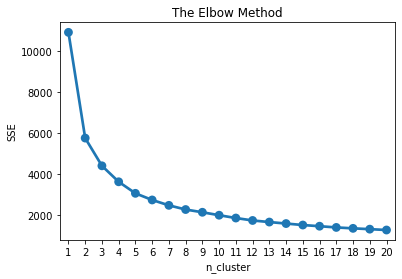

In [17]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('n_cluster')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

**Comments.** You can see the elbow is clearly around 3-4 clusters!

## 3. Profile and interpret segments
Great work on finding the right number of clusters to begin our segmentation! Now we will learn how to profile and interpret our segments.

#### Approaches to build customer personas
The are multiple ways to build customer personas. 
- You have already seen the approach where we assign the cluster label to the original dataset and then **calculate average values of each cluster**. 
- Another approach is to use **snake plots** - a chart that visualizes RFM values between the segments. 
- You also need to know how to calculate the **relative importance of each cluster's attributes** compared to the population average.

#### Summary statistics of each cluster
Ok! We will now calculate average RFM values for each of the 2 segments we have built previously. 
- First, we create a new dataframe that combines RFM values from our original dataset and the Cluster labels from the 2-cluster k-means solution.

In [18]:
datamart_rfm_k2.groupby(['Cluster']).agg({
                                            'Recency': 'mean',
                                            'Frequency': 'mean',
                                            'Monetary_Value': ['mean', 'count']
                                          }).round(1)

Recency Frequency Monetary_Value      
           mean      mean           mean count
Cluster                                       
0         137.3       5.3           91.9  2023
1          31.9      35.4          718.9  1620

- Then we aggregate RFM values and calculate their averages. 
- Finally, we compare this against a 3-cluster solution.

In [19]:
datamart_rfm_k3.groupby(['Cluster']).agg({
                                            'Recency': 'mean',
                                            'Frequency': 'mean',
                                            'Monetary_Value': ['mean', 'count']
                                          }).round(1)

Recency Frequency Monetary_Value      
           mean      mean           mean count
Cluster                                       
0          16.1      50.1         1050.6   901
1         166.6       3.0           53.0  1156
2          77.1      12.3          216.0  1586

#### Summary statistics of each cluster
As you can see there are some inherent differences between the 2-segment and 3-segment solutions.

While the former is simpler, the 3-segment solution gives more insights.

#### Snake plots to understand and compare segments
Great! Now we will learn about snake plots. 
- Snake plots are a market **research visualization technique plotting segments** and their RFM values on a **line chart**. 
- We need to **normalize** the data so the values would be comparable. 
- Finally, we plot **each cluster's average values on a line plot**.

#### Prepare data for a snake plot
Let's code the snake plot now!
- First, we create a DataFrame from our normalized NumPy array. We will pass it to the pandas DataFrame function, and use the index and columns from the original datamart_rfm. Then we will assign a cluster label from the `datamart_rfm_k3 dataset`. 

In [20]:
datamart_normalized = pd.DataFrame( data = datamart_normalized,
                                    index = datamart_rfm.index,
                                    columns = datamart_rfm.columns
                                  )
datamart_normalized['Cluster'] = datamart_rfm_k3['Cluster']

- For easier plotting, we will melt the dataset into a long format. We basically melt the three RFM columns and create one called attribute.
- The attribute column will store the name of the metric, and then store its value into another column.

In [21]:
datamart_melt = pd.melt( datamart_normalized.reset_index(),
                         id_vars = ['CustomerID', 'Cluster'],
                         value_vars = ['Recency', 'Frequency', 'Monetary_Value'],
                         var_name = 'Attribute',
                         value_name = 'Value'
                       )

- Finally, we can visualize the snake plot. We add the title and then use the lineplot function from seaborn package. We pass the attribute to the X axis, and the value to the Y axis. Finally, we pass the cluster label to the hue argument, which will draw separate lines for each cluster. And here's the snake plot - it makes it very easy and intuitive to interpret, compare the segments and identify interesting insights.

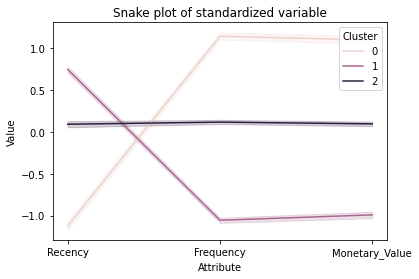

In [22]:
plt.title('Snake plot of standardized variable')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data = datamart_melt)
plt.show()

#### Relative importance of segment attributes
Now there is another technique, slightly different from the snake plot, although the underlying data preparation is similar. In general, we want our segments to differ from the overall population, and have distinctive properties of their own. We can use this technique to identify relative importance of each attribute. 

In [23]:
# - First, we calculate the average RFM values for each cluster. 
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean()

#- Then, we do the same for the total population.
population_avg = datamart_rfm.mean()

#- Finally, we divide the two, and subtract 1 from the result.
relative_imp = cluster_avg  / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,Monetary_Value
Cluster,,,
0,-0.82,1.68,1.83
1,0.84,-0.84,-0.86
2,-0.15,-0.34,-0.42


#### Analyze and plot relative importance
The result is a relative importance score for each RFM value of the segments. The further that ratio is from zero, the more important that attribute is for defining a specific cluster compared to the population average. We can view it by just looking at rounded values, or we can plot a heatmap which we used in our first lesson on cohort analysis.

#### Relative importance heatmap
Here we go - the heatmap plot is easier to interpret, and it contains the actual numeric values as well. If you compare it to the previous printed output, it's clear that the heatmap has a visual advantage over the print() statement.

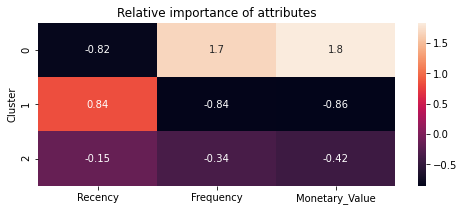

In [24]:
plt.figure(figsize = (8, 3))
plt.title('Relative importance of attributes')
sns.heatmap(data = relative_imp, annot = True)
plt.show()

### 3.2. PRACTICES
#### Exercise 3.2.1. Prepare data for the snake plot
Now you will prepare data for the snake plot. You will use the 3-cluster RFM segmentation solution you have built previously. You will transform the normalized RFM data into a long format by "melting" the metric columns into two columns - one for the name of the metric, and another for the actual numeric value.
#### SOLUTION.

In [25]:
# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(
      					datamart_normalized.reset_index(), # reset the index in original dataset
                        id_vars = ['CustomerID', 'Cluster'], # Assign CustomerID and Cluster as ID variables
                        value_vars = ['Recency', 'Frequency', 'Monetary_Value'], # Assign RFM values as value variables
                        var_name='Metric', value_name='Value' # Name the variable and value
					)

#### Exercise 3.2.2. Visualize snake plot
Good work! You will now use the melted dataset to build the snake plot. The melted data is loaded as datamart_melt.
#### SOLUTION.

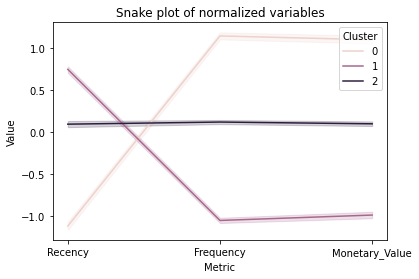

In [26]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

#### Exercise 3.2.3. Calculate relative importance of each attribute
Now you will calculate the relative importance of the RFM values within each cluster.
#### SOLUTION.

In [27]:
# Calculate average RFM values for each cluster
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = datamart_rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

         Recency  Frequency  Monetary_Value
Cluster                                    
0          -0.82       1.68            1.83
1           0.84      -0.84           -0.86
2          -0.15      -0.34           -0.42


#### Exercise 3.2.4. Plot relative importance heatmap
Great job! Now you will build a heatmap visualizing the relative scores for each cluster.
#### SOLUTION

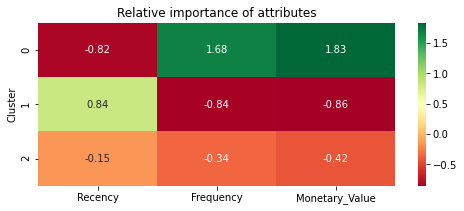

In [28]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 3))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

## 4. Implement end-to-end segmentation solution
Fantastic work! You are now fully equipped to build end-to-end customer segmentation projects and that's what we're going to do now.

#### Key steps of the segmentation project
Now, let's recap the key steps of the segmentation project. 
- First, you **gather the data**. You will use an updated dataset that has recency, frequency and monetary values from the previous lessons, and an additional variable to make this more interesting.
- Then, you will **pre-process** the data to ensure k-means clustering works as expected.
- Next, you will use the techniques from the previous lessons to **identify the number of clusters**. 
- Finally, you will run the k-means clustering, and then **use various analysis and visualization techniques to interpret the results**.

#### Updated RFM data
Now, we have created an updated version of our RFM dataset. The additional variable called `tenure` has been added.

In [29]:
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days = 1)
datamart_rfmt = online.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                                'InvoiceNo': 'count',
                                                'Total_Sum': 'sum'
                                              })
x = online.groupby(['CustomerID']).max()['InvoiceDate'] - online.groupby(['CustomerID']).min()['InvoiceDate']
datamart_rfmt['Tenure'] = x.dt.days + 2

# Rename
datamart_rfmt = datamart_rfmt.rename(columns =
                                             {'InvoiceDate': 'Recency',
                                               'InvoiceNo': 'Frequency',
                                               'Total_Sum': 'MonetaryValue'}
                                     )
datamart_rfmt.head()

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12747,3,25,948.70,361
12748,1,888,7046.16,366
12749,4,37,813.45,212
12820,4,17,268.02,325
12822,71,9,146.15,19


This value is calculated as the time since the first transaction, as opposed to recency which is the time since the customer's last transaction. Ultimately, it defines how long the customer has been with the company since their first transaction. And here's the data - as you can see it has the RFM values as previously, and the new tenure feature as the last column.

#### Goals for this project
Now that you've seen the data, you can start working on the final segmentation project. The main goals for running this end-to-end segmentation solution are: 
- First, remember the key pre-processing rules and steps. 
- Second, apply data exploration techniques and identify the number of segments to be used. 
- Then, you will practice running several k-means iterations, and interpret the results by applying quantitative and visual techniques.

### 4.2. PRACTICES
#### Exercise 4.2.1. Pre-process data
First step in the segmentation process is to pre-process the data. You will apply log transformation, and then normalize the data to prepare it for clustering.
#### SOLUTION.

In [30]:
# Import StandardScaler 
from sklearn.preprocessing import StandardScaler

# Apply log transformation
datamart_rfmt_log = np.log(datamart_rfmt)

# Initialize StandardScaler and fit it 
scaler = StandardScaler()
scaler.fit(datamart_rfmt_log)

# Transform and store the scaled data as datamart_rfmt_normalized
datamart_rfmt_normalized = scaler.transform(datamart_rfmt_log)

#### Exercise 4.2.2. Calculate and plot sum of squared errors
Now, you will calculate the sum of squared errors for different number of clusters ranging from 1 to 10.
#### SOLUTION.

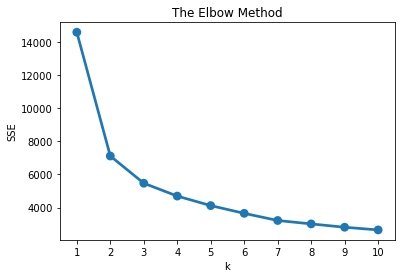

In [31]:
sse = {}

# Fit KMeans and calculate SSE for each k between 1 and 10
for k in range(1, 11):
  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=k, random_state=1).fit(datamart_rfmt_normalized)
    
    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_

# Add the plot title, x and y axis labels
plt.title('The Elbow Method'); plt.xlabel('k'); plt.ylabel('SSE')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

**Comments.** The elbow is visible around 3-4 clusters!

#### Exercise 4.2.3. Build 4-cluster solution
Perfect, you can see the the recommended number of clusters is somewhere between 3 and 4. Now, you will build the latter number of clusters in this exercise.
#### SOLUTION.

In [32]:
# Initialize KMeans
kmeans = KMeans(n_clusters=4, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_rfmt_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

#### Exercise 4.2.4. Analyze the segments
Fantastic! Final step - analyzing your segmentation solution - you will analyze the average Recency, Frequency, MonetaryValue and Tenure values for each of the four segments you have built previously. Take some time to analyze them and understand what kind of customer groups and behaviors they represent.
#### SOLUTION.

In [33]:
# Create a new DataFrame by adding a cluster label column to datamart_rfmt
datamart_rfmt_k4 = datamart_rfmt.assign(Cluster = cluster_labels)

# Group by cluster
grouped = datamart_rfmt_k4.groupby(['Cluster'])

# Calculate average RFMT values and segment sizes for each cluster
grouped.agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'MonetaryValue': ['mean', 'count'],
            'Tenure': ['mean', 'count']
          }).round(1)

Recency Frequency MonetaryValue       Tenure      
           mean      mean          mean count   mean count
Cluster                                                   
0          15.8      50.9        1075.6   873  256.8   873
1         122.6       7.3         123.6   831    2.8   831
2         171.5       2.0          33.7   694    4.3   694
3          76.2      13.1         229.2  1245  161.2  1245